# Simulate data using behavioral model and perform parameter recovery

There are 3 models with different parameter combinations:

1. <b>The Bayesian model (Schwöbel et al. 2021):</b> \
   <b>a.</b> With 3 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, and a decision temparature $\beta$. \
   <b>b.</b> With 4 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, a decision temparature $\beta$, and a habitual tendency $h$.
2. <b>A newer MF/MB version that is better for fitting (Otto et al. 2013):</b> \
<b>Note:</b> This is not quite the original version, as the Q-values in the original work did not converge to the true expected values. Instead, I implemented a "bug-fixed" version.\
   <b>a.</b> With 4 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$$, and a repetition/perserveration parameter $p$. \
3. <b>The original model-free/model-based (MF/MB) model (Daw et al. 2005, 2011):</b> \
   <b>a.</b> With 4 parameters: a weighting parameters $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a weighting parameter $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, a dicount factor $\lambda$, and a repetition/perserveration parameter $p$.

Tell python that the code in the submodule is code that we want to import and run

In [1]:
import sys
import os
current_dir = os.path.abspath('')
os.chdir(current_dir)
sys.path.append(os.path.join(current_dir,'..','code','BalancingControl'))

import two_stage_utils as tu
import inference as inf

torch threads 1
Running on device cpu


Other imports that we need for simulation, inference, and plotting

In [2]:
import torch
import pyro

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
#import jsonpickle as pickle
import json
import gc
import pickle

Where second stage random walks from the experiment are stored

In [3]:
Rho_data_fname = os.path.join("experiment", "dawrandomwalks.mat")

Define where results should be saved

In [4]:
results_folder = "results"
simulation_folder = os.path.join(results_folder, "simulations")
cross_fitting_folder = os.path.join(results_folder, "cross_fitting")

mask_file_name = "mask.txt"
processed_data_folder = os.path.join(results_folder, "processed_data")
mask_file = os.path.join(processed_data_folder, mask_file_name)

#### Global experiment parameters

In [5]:
# number of simulated agents/participants
n_agents = 24

In [6]:
trials =  272#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
# with open(mask_file, "rb") as f:
#     all_mask = pickle.load(f)
# # simulations will be done with the same missing actions as in the data.
# exp_mask = torch.tensor(all_mask).permute((1,0))
p_valid = 0.01

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward}#, "p_invalid": p_valid, "mask": exp_mask}

Define states and transition matrices

In [7]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

Now we can start :) 

Load stored simulation results of BCC3

Simulation pre-setup

In [8]:
# set parameters and their names

use_orig = False

use_p = False
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str
fname_base = prefix+p_str+restr_str+"_simulation_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(simulation_folder,fname_base[:-1])

mbmf_4param_simulation_


In [9]:
print("loading simulated outputs...")

stayed_arr, true_vals, data = tu.load_simulation_outputs(base_dir, agent_type)

n_true = true_vals["subject"].max() + 1
n_data = data["subject"].max() + 1

assert n_true == n_data == n_agents, f"the numbers of agents dont match! They are: {n_true}, {n_data}, {n_agents}. Probably rerun simulations to fix."

print("true values are:")
print(true_vals)

loading simulated outputs...
true values are:
{'subject': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23]]), 'discount': tensor([[0.1597, 0.6867, 0.0051, 0.0488, 0.2269, 0.5804, 0.7652, 0.6020, 0.4287,
         0.9152, 0.9673, 0.6512, 0.1654, 0.9390, 0.7622, 0.6167, 0.4560, 0.8998,
         0.9934, 0.0686, 0.4158, 0.8649, 0.2884, 0.1223]]), 'learning rate': tensor([[0.8005, 0.3207, 0.3054, 0.7071, 0.9622, 0.8252, 0.5026, 0.6800, 0.1833,
         0.8341, 0.2825, 0.5448, 0.3548, 0.8768, 0.7473, 0.4197, 0.9723, 0.4417,
         0.3284, 0.3269, 0.8399, 0.4132, 0.0246, 0.1293]]), 'mf weight': tensor([[2.6154, 5.9025, 3.1007, 1.3961, 1.4997, 5.4128, 1.6530, 0.6856, 0.5252,
         3.4135, 2.2514, 4.2994, 3.6306, 5.8824, 0.5009, 3.2185, 0.4603, 2.1323,
         4.8635, 0.6904, 3.2861, 5.2165, 2.3217, 4.3435]]), 'mb weight': tensor([[3.3301, 5.1825, 3.3751, 2.9850, 5.0070, 0.0627, 1.9515, 2.5859, 5.2173,
         2.4236, 0.2574

Plot simulated stay probability

/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/hom

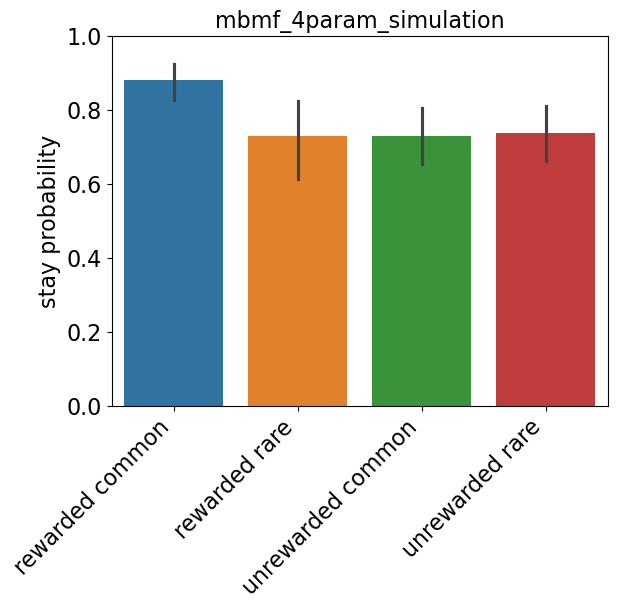

In [10]:
bar_names = ["rewarded common", "rewarded rare", "unrewarded common", "unrewarded rare"]

plt.figure()
g = sns.barplot(data=stayed_arr)
g.set_xticklabels(bar_names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0,1])
plt.yticks(torch.arange(0,1.1,0.2),fontsize=16)
plt.ylabel("stay probability", fontsize=16)
plt.title(fname_base[:-1], fontsize=16)
plt.savefig(os.path.join(base_dir,"simulated_stay_probs.svg"),dpi=300)
plt.show()

#### Inference: we will analyze BCC3 data with the BCC4 model

Simulation pre-setup

In [11]:
# set parameters and their names

use_orig = False

use_p = True
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str
fname_base = prefix+p_str+restr_str+"_simulation_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(simulation_folder,fname_base[:-1])

mbmf_5param_simulation_


Inference pre-setup

In [12]:
# prepare for saving results
# make base filename and folder string
fname_base = "MFMB4param_cross_fitting_"+agent_type
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(cross_fitting_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(cross_fitting_folder):
    os.mkdir(base_dir)

# how many inference steps
num_steps = 500

MFMB4param_cross_fitting_mbmf_5param


<b>Decide</b> for running or loading inference

In [13]:
run_inference = True

<b>Either:</b> Set up agent and inference. Run main inference loop, plot intermediate and end results

analyzing 24 data sets
this is inference using <class 'inference.GeneralGroupInference'>
taking steps 1 to 100 out of total 500


Mean ELBO 3726.47: 100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


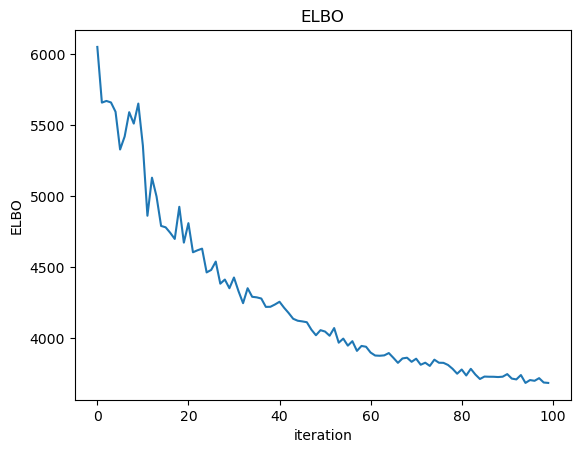

<Figure size 640x480 with 0 Axes>

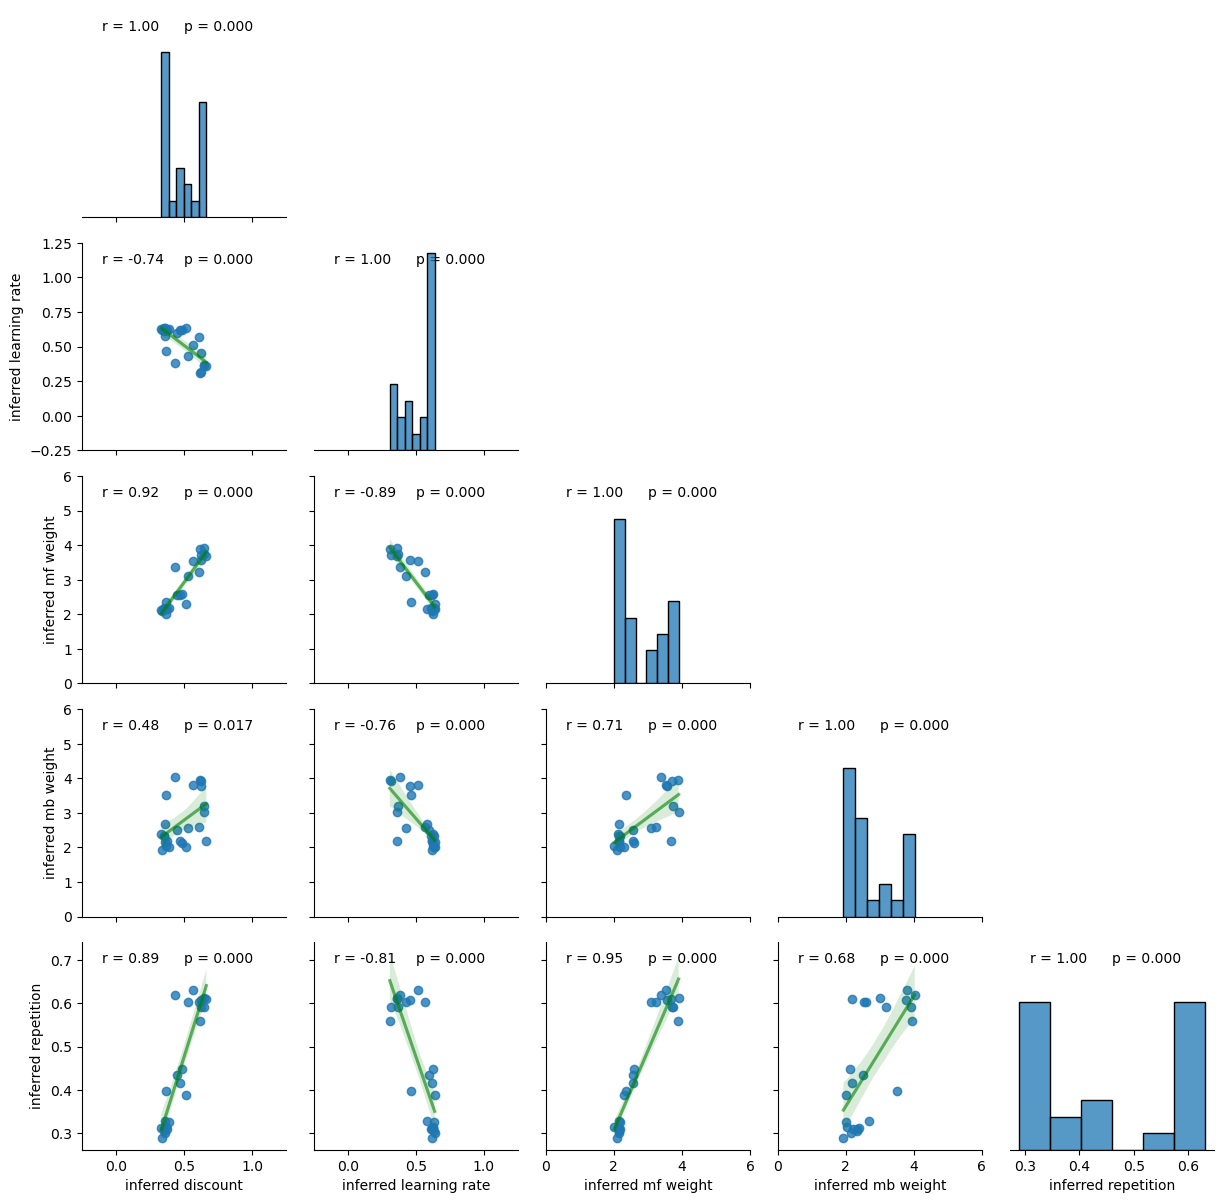

taking steps 101 to 200 out of total 500


Mean ELBO 3506.34: 100%|██████████| 100/100 [03:50<00:00,  2.31s/it]


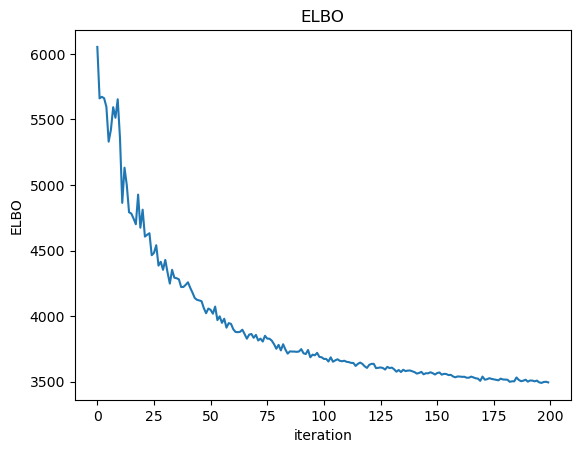

<Figure size 640x480 with 0 Axes>

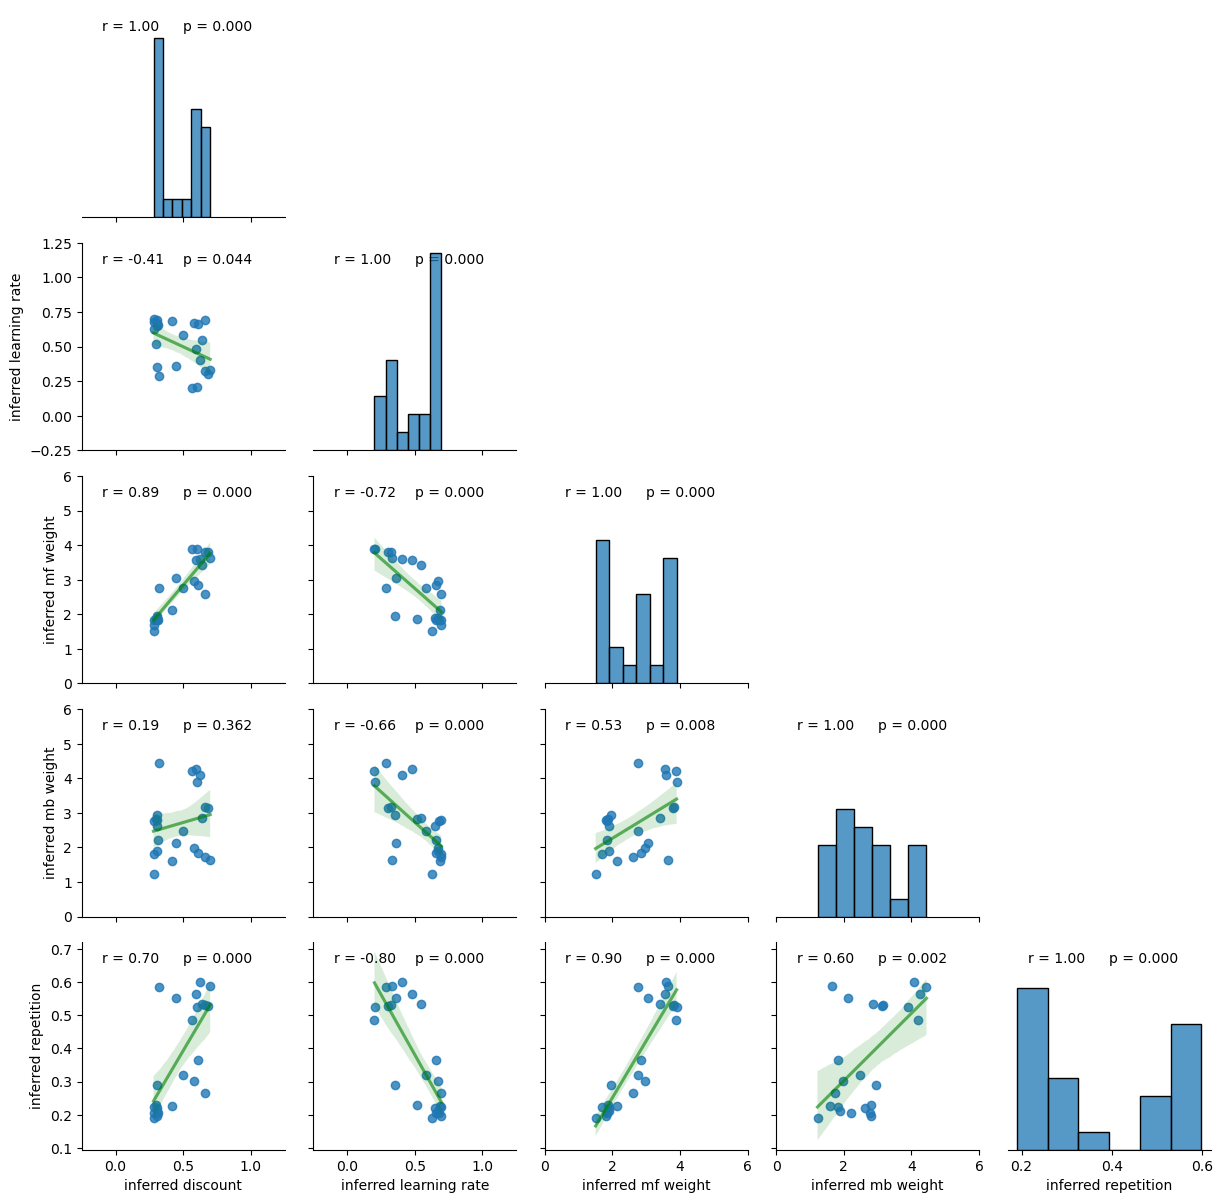

taking steps 201 to 300 out of total 500


Mean ELBO 3432.25: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


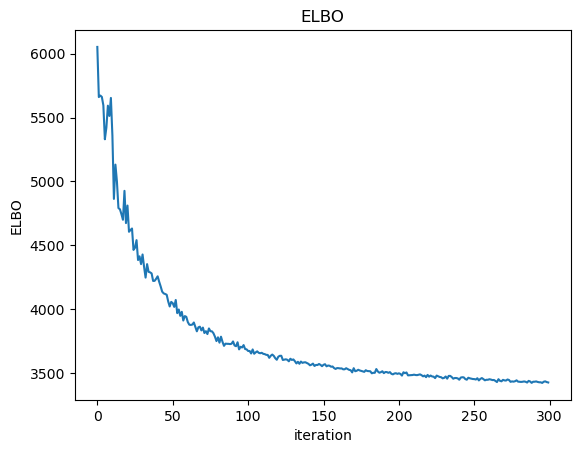

<Figure size 640x480 with 0 Axes>

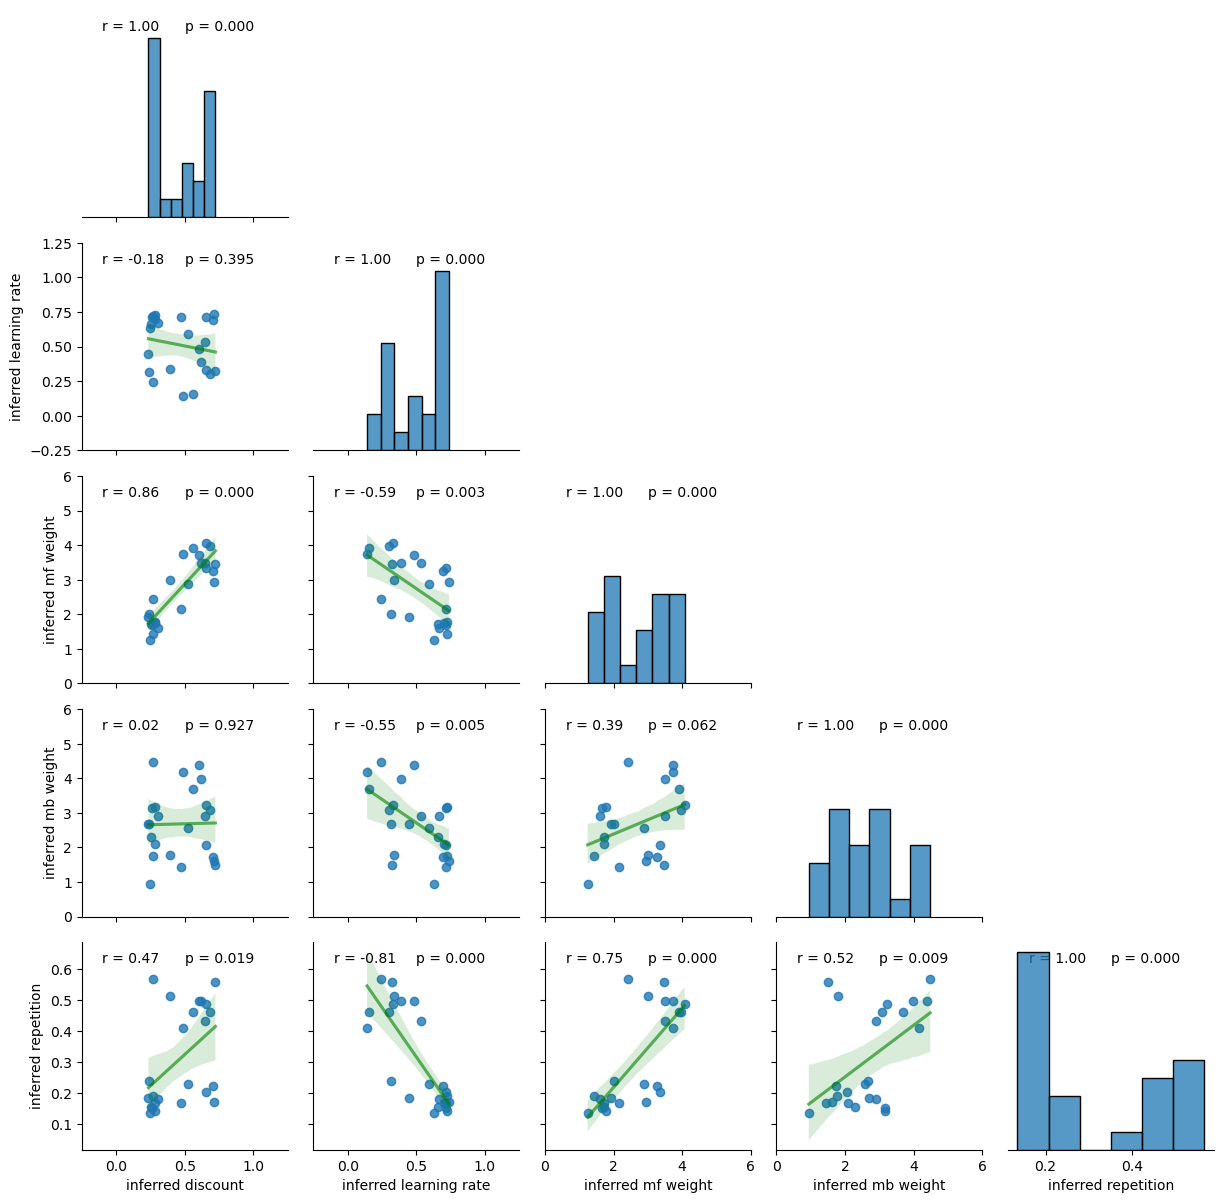

taking steps 301 to 400 out of total 500


Mean ELBO 3395.92: 100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


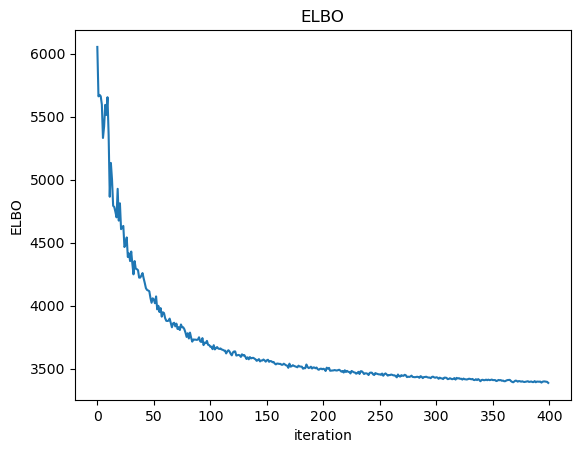

<Figure size 640x480 with 0 Axes>

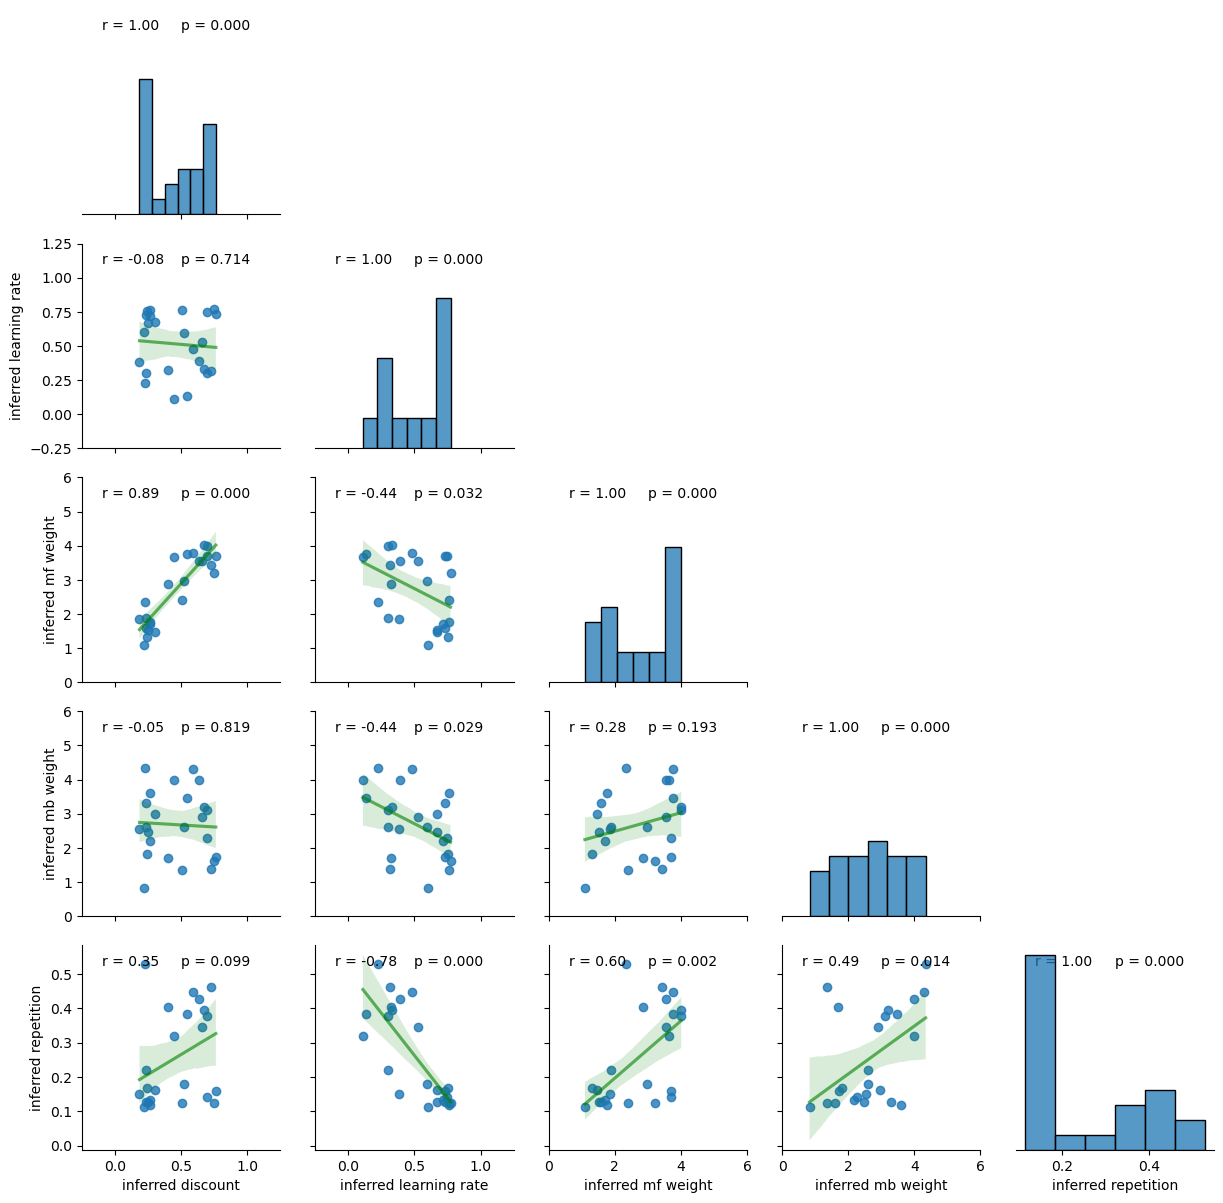

taking steps 401 to 500 out of total 500


Mean ELBO 3374.88: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


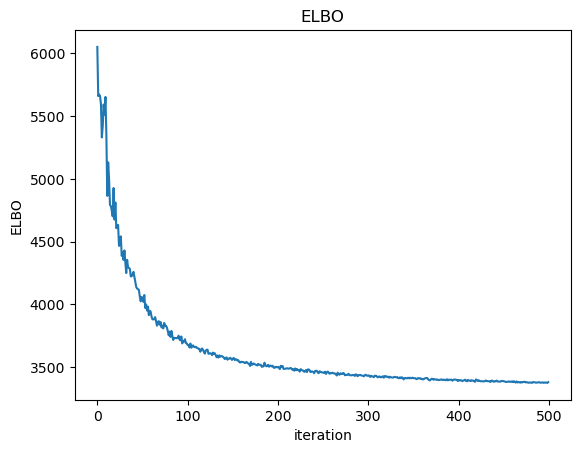

<Figure size 640x480 with 0 Axes>

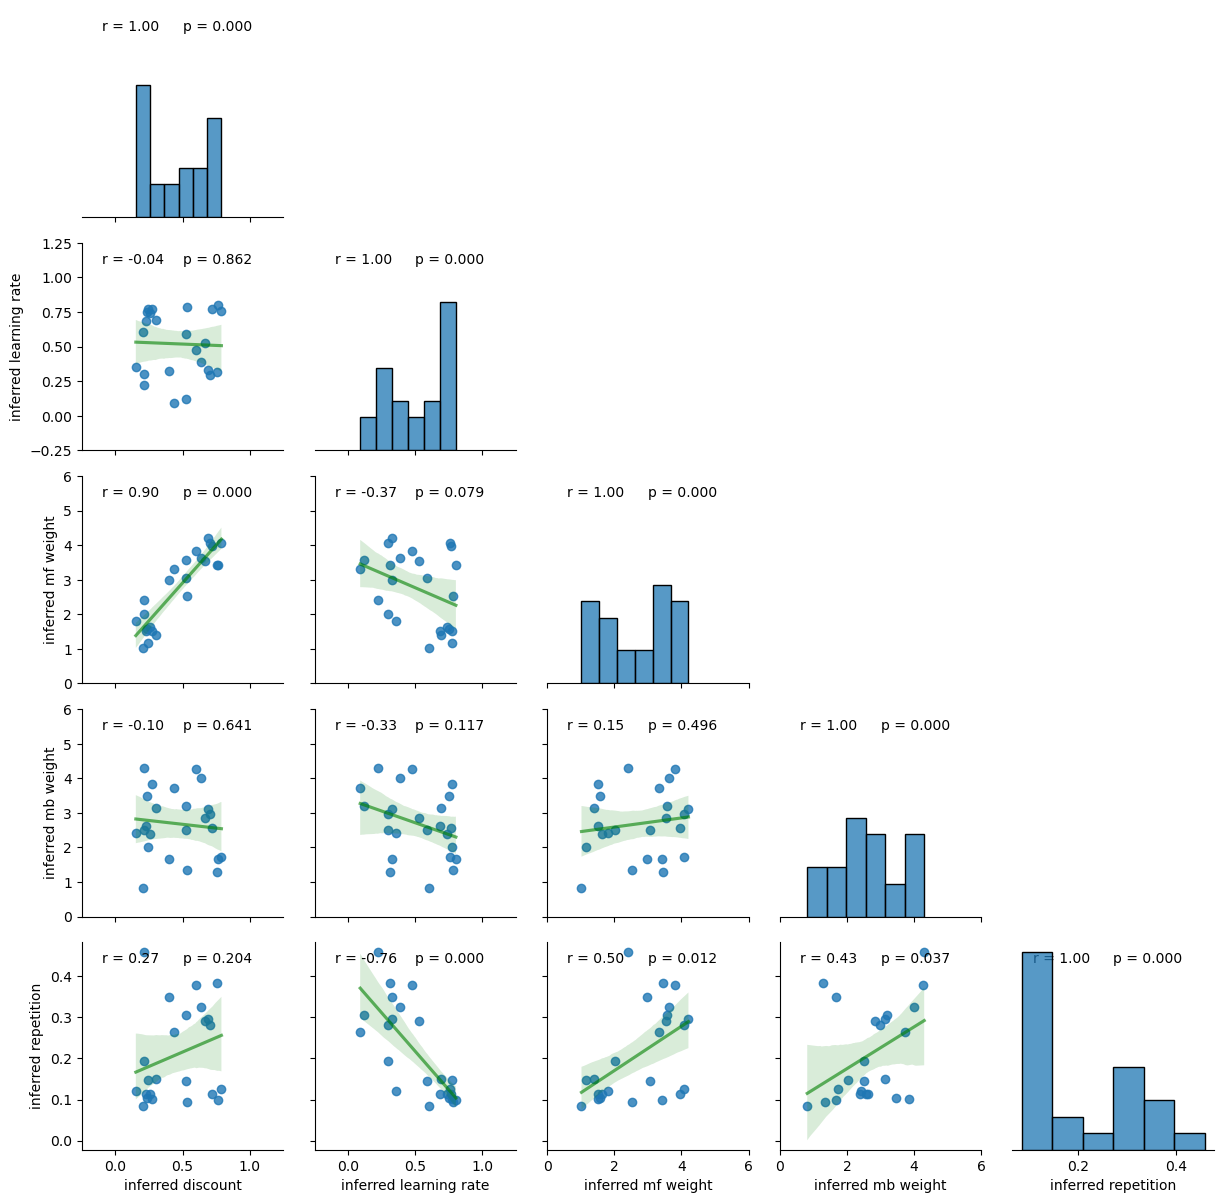

In [14]:
if run_inference:

    # remove old inference?
    remove_old = False

    # set up agent
    bayes_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=remove_old)

    print('analyzing '+str(n_agents)+' data sets')

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    num_particles = 15


    print("this is inference using", type(inferrer))
    
    size_chunk = 100
    total_num_iter_so_far = 0

    for i in range(total_num_iter_so_far, num_steps, size_chunk):
        print('taking steps '+str(i+1)+' to '+str(i+size_chunk)+' out of total '+str(num_steps))

        fname_str = fname_base + str(total_num_iter_so_far+size_chunk)+'_'+str(n_agents)+'agents'

        tu.infer(inferrer, size_chunk, fname_str, num_particles, base_dir)
        total_num_iter_so_far += size_chunk

        inferrer.save_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

        inferrer.save_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
        param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

        plt.figure()
        vars_of_interest = ["inferred "+name for name in param_names]
        f = sns.pairplot(data=mean_df, kind='reg', diag_kind="hist", corner=True,
                            plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                            grid_kws={"layout_pad": 1.5},
                            x_vars=vars_of_interest, y_vars=vars_of_interest)
        f.map(tu.annot_corrfunc)
        for p, p_range in enumerate(param_plot_ranges):
            f.axes[3,p].set_xlim(p_range)
            f.axes[p,0].set_ylim(p_range)
        plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
        plt.show()

    # sample from posterior only at last time step and save results. Could be done at every step, if earlier posteriors are of interest, one can load the inferrer save and sample from that.
    mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 

<b>Or:</b> Set up agent and inference. Load past inference, decide whether to resample posterior or used stored samples

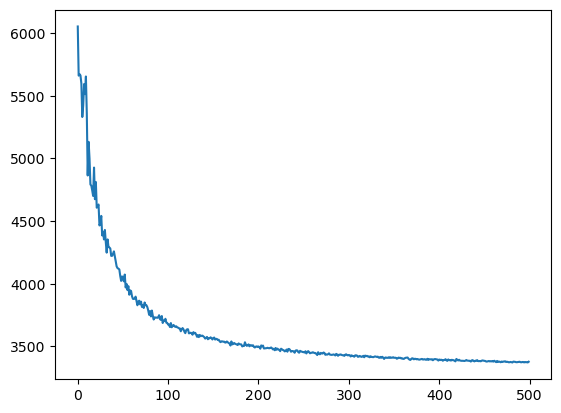

last ELBO: tensor(3377.5596)


In [15]:

if not run_inference:

    # set up agent
    mfmb_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = True

    # set up inference
    inferrer = inf.GeneralGroupInference(mfmb_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

plt.figure()
plt.plot(inferrer.loss)
plt.show()
print("last ELBO:", inferrer.loss[-1])

<Figure size 640x480 with 0 Axes>

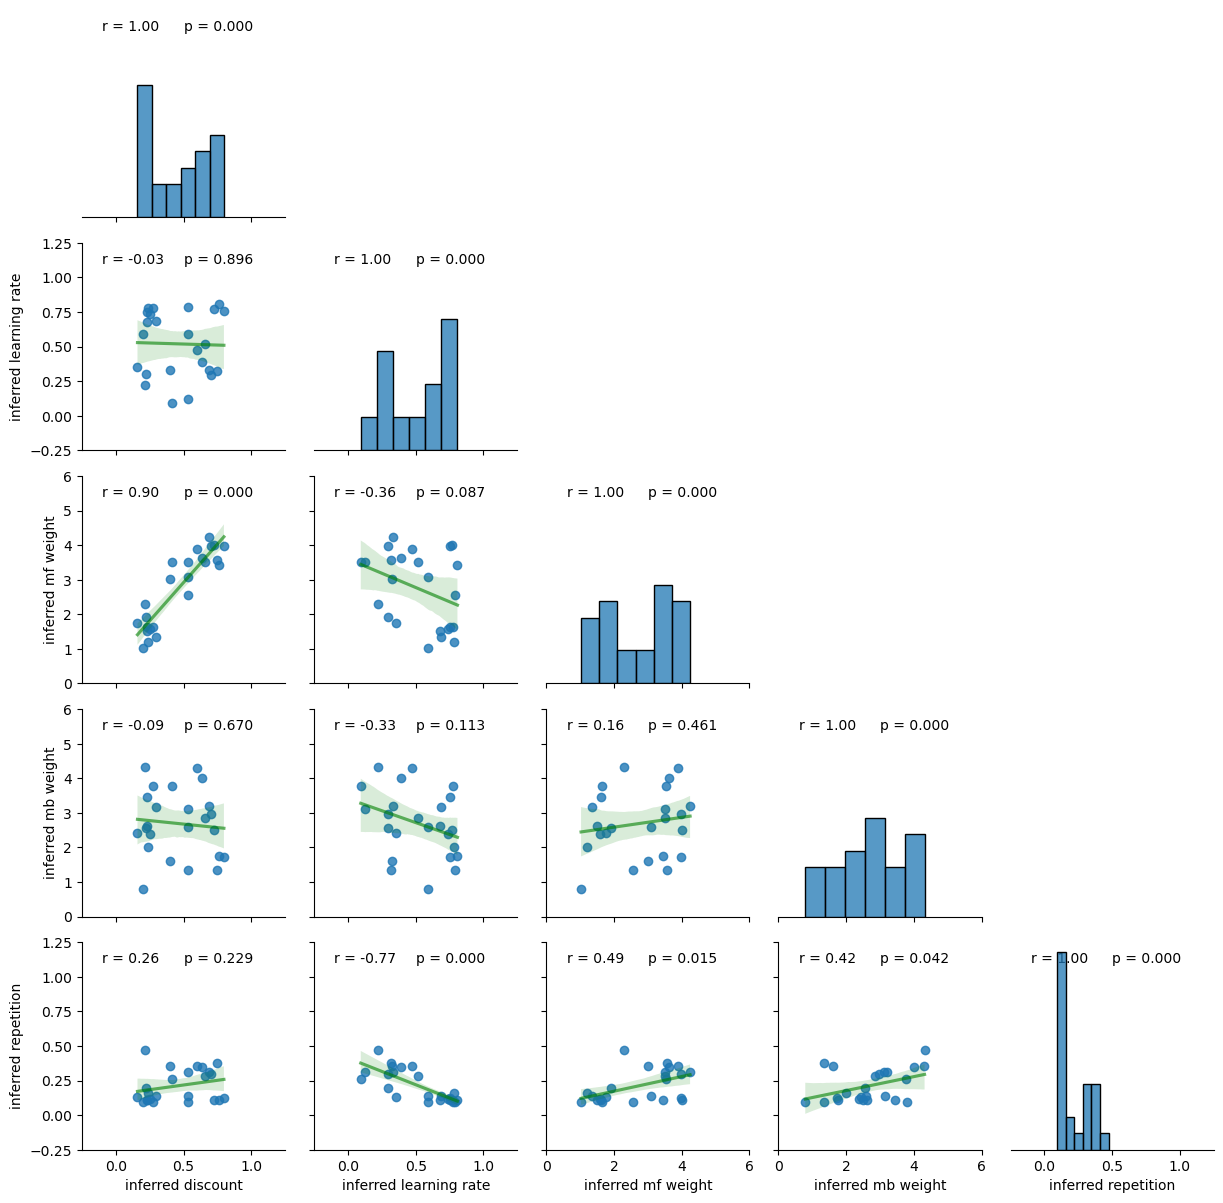

This is inference for the twostage task using the two beta mbmf model(mbmf_5param) with 24 agents.
The settings are: infer p True restrict alpha False


In [16]:
param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt], [0,1]]

param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt], [-0.25,1.25]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    grid_kws={"layout_pad": 1.5},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[4,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+p_str+restr_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer p", use_p, "restrict alpha", restrict_alpha)